<a href="https://colab.research.google.com/github/ab17254/dissertation/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload config.py with API keys
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [2]:
import os
from config import KaggleKey
os.environ['KAGGLE_USERNAME'] = KaggleKey.kaggle_username
os.environ['KAGGLE_KEY'] = KaggleKey.kaggle_key
!kaggle datasets download -d albrace/twitter-data

 98% 767M/779M [00:06<00:00, 144MB/s]
100% 779M/779M [00:06<00:00, 126MB/s]


In [3]:
!unzip /content/twitter-data.zip -d /content/data

Archive:  /content/twitter-data.zip
  inflating: /content/data/2019_all_twitter_data/2019_all_twitter_data.csv  
  inflating: /content/data/clean_twitter_data/all_2019.csv  
  inflating: /content/data/clean_twitter_data/all_users.csv  
  inflating: /content/data/clean_twitter_data/pol_actor_users.csv  
  inflating: /content/data/ge2017_cand_data/ge2017_cand_data.csv  
  inflating: /content/data/twitter_data/all_twitter_data.csv  
  inflating: /content/data/twitter_data/political_twitter_data.csv  


In [28]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 122kB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from operator import itemgetter

import re
import tweepy
from tweepy import OAuthHandler
from config import TwitterKeys

In [5]:
consumer_key = TwitterKeys.consumer_key
consumer_secret = TwitterKeys.consumer_secret
access_token = TwitterKeys.access_token
access_token_secret = TwitterKeys.access_token_secret

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
twitter_api = tweepy.API(auth,  wait_on_rate_limit=True)

twitter_app_auth = {
    'consumer_key': consumer_key,
    'consumer_secret': consumer_secret,
    'access_token': access_token,
    'access_token_secret': access_token_secret,
  }

In [4]:
pol_df = pd.read_csv('/content/data/clean_twitter_data/all_2019.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
pol_df.isnull().sum()

tweet_date                          0
tweet_content                       0
tweet_id                            0
tweet_likes                         0
tweet_replies                       0
tweet_retweets                      0
tweet_quotes                        0
user_username                       0
user_id                             0
user_followers                      0
user_friends                        0
user_statuses                       0
user_verified                       0
user_url                            0
tweet_url                           0
quotedTweet_id                 890694
quotedTweet_content            890694
quotedTweet_username           890694
quotedTweet_userID             890694
hashtags                            0
clean_tweet_content                 0
mentioned_users                749691
quotedTweet_mentionedUsers    1086388
clean_sentiment_content           148
dtype: int64

In [5]:
pol_df = pol_df.dropna(subset=['quotedTweet_username'])


In [42]:
interactions_df = pd.DataFrame(columns=['user_username', 'quotedTweet_username'])
user = []
mentions = []
for row in pol_df.iterrows():
  user.append(row[1]['user_username'])
  mentions.append(row[1]['quotedTweet_username'])
interactions_df['user_username'] = user
interactions_df['quotedTweet_username'] = mentions
interactions_df['quotedTweet_username'] = interactions_df['quotedTweet_username'].str.split()

In [43]:
interactions_df = interactions_df.dropna()

In [44]:
interactions = []
for row in interactions_df.iterrows():
  user = row[1][0]
  mentions = row[1][1]
  for mention in mentions:
    interactions.append((user, mention))

In [46]:
interactions_df = pd.DataFrame(interactions, columns=['user_username', 'quotedTweet_username'])

In [51]:
interactions_df

,user_username,quotedTweet_username
0,ManxFreeState,Peston
3,NickWithey1,IanMurrayMP
4,draperel,Melissa_Benn
5,Guti_Ivan,BritainElects
6,CitizenKayS,PGourevitch
...,...,...
257385,stmgtthepious,liamyoung
257386,Amethystra80,leehealey_
257387,stmgtthepious,JamesEFoster
257388,stmgtthepious,BBCBreakfast


In [48]:
interactions_df = interactions_df.replace('nan', np.nan)
interactions_df = interactions_df.dropna()

In [49]:
interactions_df['user_username'] = interactions_df['user_username'].astype('str')
interactions_df['quotedTweet_username'] = interactions_df['quotedTweet_username'].astype('str')

In [50]:
interactions_df=interactions_df.drop([1,2])

In [54]:
interactions_sample = interactions_df.sample(n=5000)

In [55]:
graph = nx.from_pandas_edgelist(interactions_sample, 'user_username', 'quotedTweet_username')
pos = nx.spring_layout(graph)


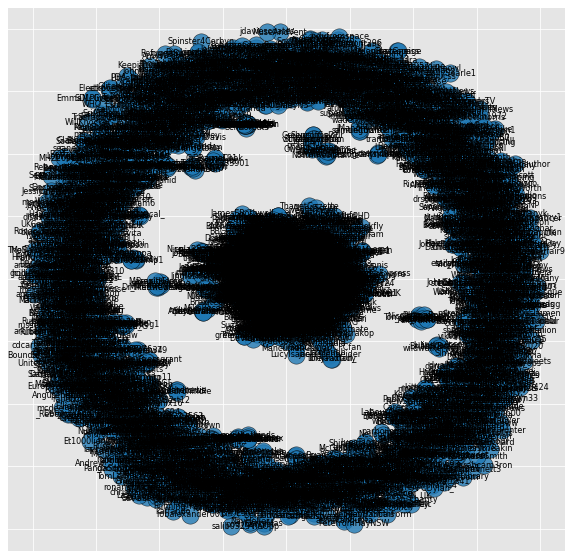

In [56]:
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(graph, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(graph, pos, font_size=8)
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.2)

In [57]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 5725 nodes and 4903 edges present in the Graph
The maximum degree of the Graph is 225
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 1.7
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 1339 connected components in the Graph


In [58]:
largest_subgraph=list(graph.subgraph(c) for c in nx.connected_components(graph))[0]
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

    
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

There are 2774 nodes and 3147 edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 1.0530105158800185e-05 in the largest subgraph
The transitivity of the largest subgraph is 6.27418174213113e-05
The diameter of our Graph is 20
The average distance between any two nodes is 6.78


In [59]:
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id jeremycorbyn has a degree centrality of 0.08 which is the maximum of the Graph
the node with id jeremycorbyn has a closeness centrality of 0.25 which is the maximum of the Graph
the node with id jeremycorbyn has a betweenness centrality of 0.43 which is the maximum of the Graph


In [63]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange']
central_nodes = ['jeremycorbyn']
pos = nx.spring_layout(largest_subgraph, k=0.05)

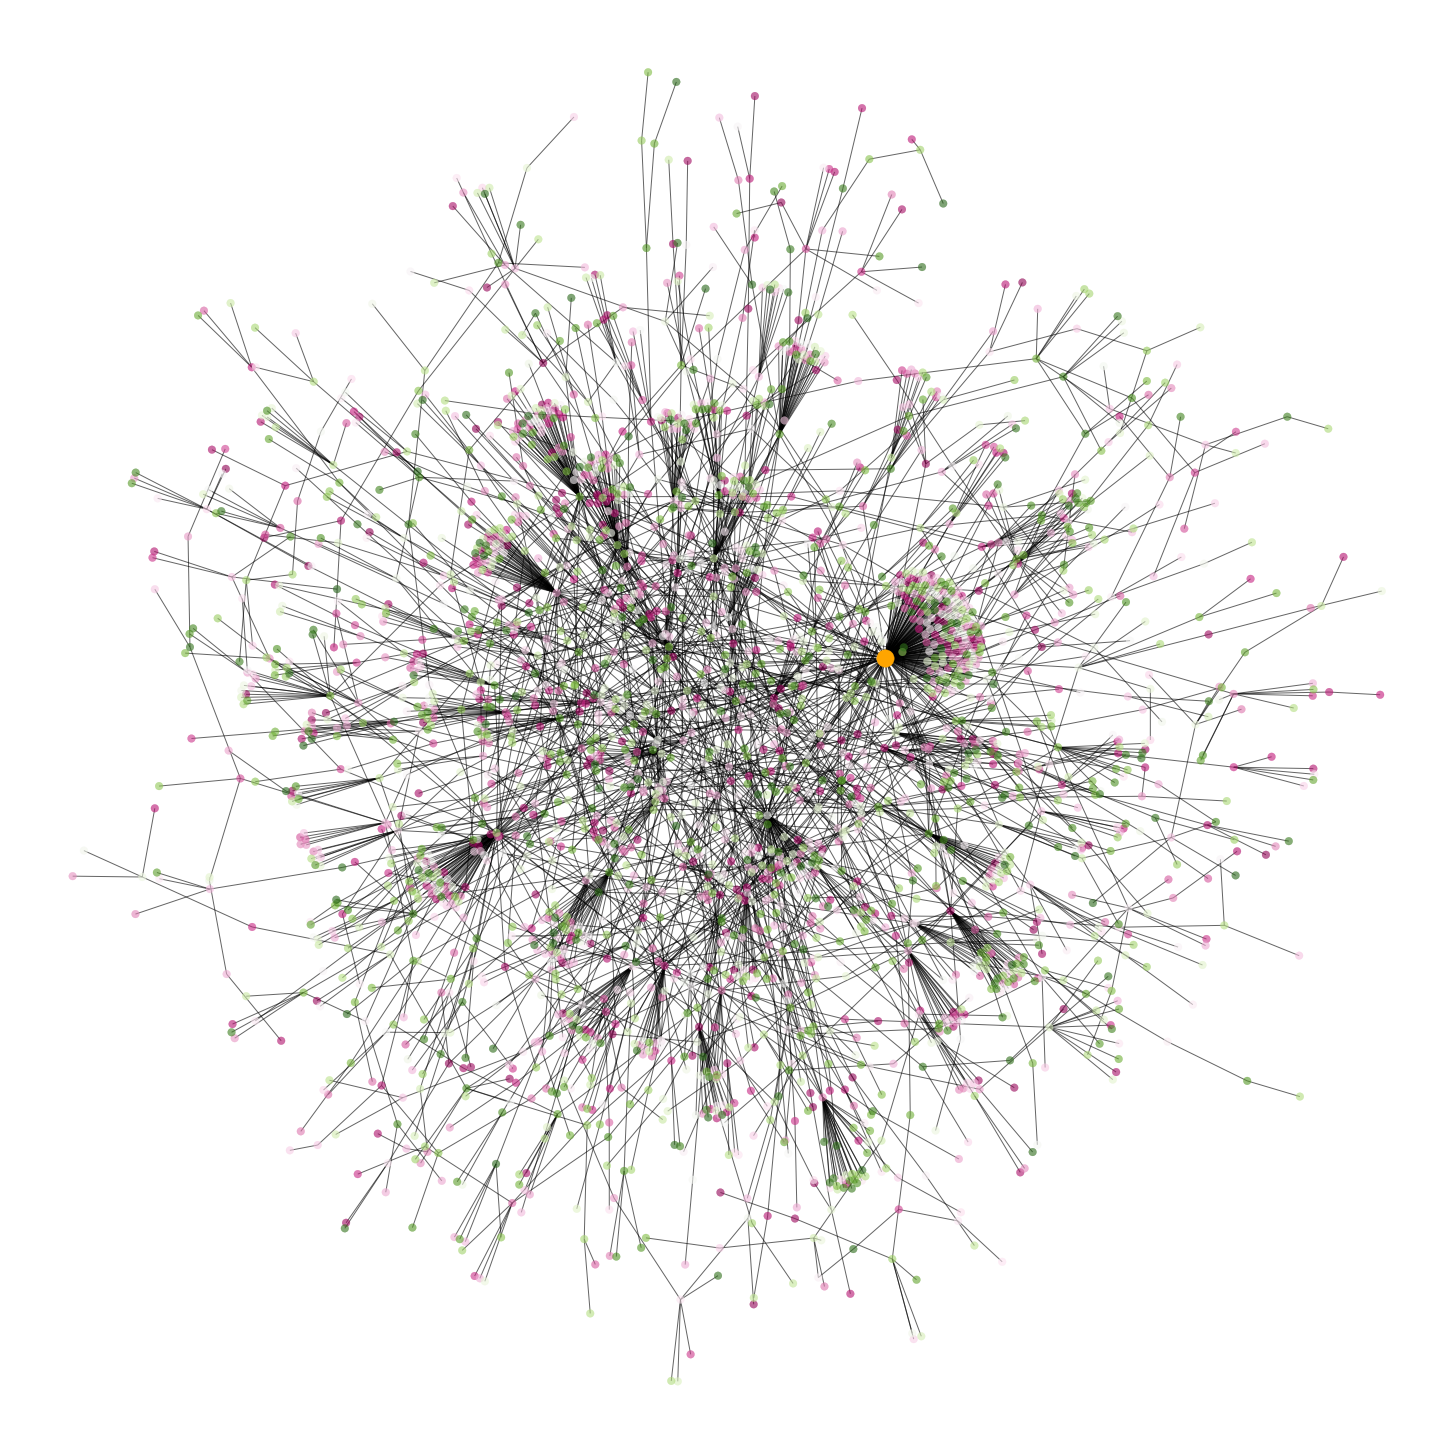

In [64]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(2774), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.show()

In [ ]:
from community import community_louvain
partition = community_louvain.best_partition(largest_subgraph)
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['names','group']

In [ ]:
G_sorted = pd.DataFrame(sorted(largest_subgraph.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['names','degree']
G_sorted.head()
dc = G_sorted

In [ ]:
combined = pd.merge(dc,partition1, how='left', left_on="names",right_on="names")

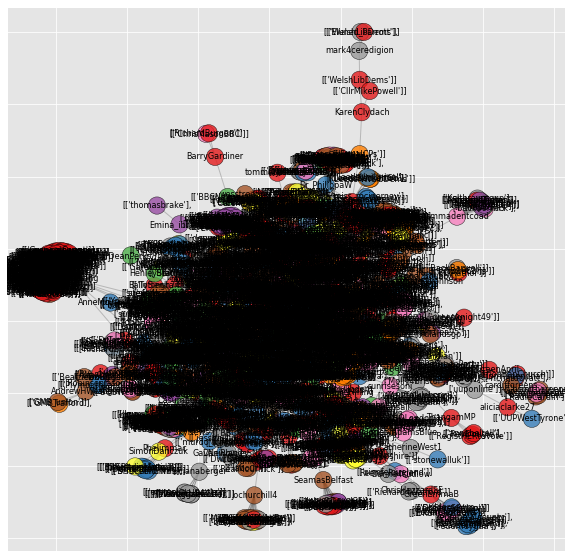

In [ ]:
pos = nx.spring_layout(largest_subgraph)
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(largest_subgraph, pos,
                               cmap=plt.cm.Set1,
                               node_color=combined['group'],
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(largest_subgraph, pos, font_size=8)
nx.draw_networkx_edges(largest_subgraph, pos, width=1.0, alpha=0.2)

In [ ]:
edges = nx.to_pandas_edgelist(largest_subgraph)
edges.to_csv("edges.csv")

combined = combined.rename(columns={"names": "Id"})
nodes = combined['Id']
combined.to_csv('nodes.csv')

### Similarity Matrix

In [6]:
pol_df = pol_df.sample(n=5000)

In [7]:
pol_df = pol_df.reset_index(drop=True)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(pol_df['quotedTweet_content'])
print(tfidf_matrix.shape)

(5000, 17801)


In [9]:
pol_df['quotedTweet_content'][0]

"b'Exit Poll Forecast: Conservative Majority #BBCelection #GE2019 https://t.co/epJYYpRo2y'"

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_index=cosine_similarity(tfidf_matrix[0],tfidf_matrix)
similarity_index=similarity_index.reshape(-1)

In [38]:
n=6
print(similarity_index[np.argsort(similarity_index)[-n:]])

[0.70259853 0.85634023 1.         1.         1.         1.        ]


In [39]:
res = sorted(range(len(similarity_index)), key = lambda sub: similarity_index[sub])[-n:] 
  
# printing result 
print("Indices list of max N elements is : " + str(res))

Indices list of max N elements is : [4197, 4737, 0, 2020, 2911, 3969]


In [40]:
for i in res:
    print(pol_df['quotedTweet_content'][i], i)
    print('\n')

b'Why Conservative Remainers are so important...\n\n16% of Remainers are still planning on voting Conservative (YouGov 2-3 Dec)\n\nOut of those who voted Remain in 2016 and Conservative in 2017, 63% plan on voting Conservative again (Deltapoll 28-30 Nov)\n\n#GE2019' 4197


b'Exit poll Conservative 368 Labour 191 Liberal Democrat  SNP  Others #ge2019 #auspol Conservative majority' 4737


b'Exit Poll Forecast: Conservative Majority #BBCelection #GE2019 https://t.co/epJYYpRo2y' 0


b'Exit Poll Forecast: Conservative Majority #BBCelection #GE2019 https://t.co/epJYYpRo2y' 2020


b'Exit Poll Forecast: Conservative Majority #BBCelection #GE2019 https://t.co/epJYYpRo2y' 2911


b'Exit Poll Forecast: Conservative Majority #BBCelection #GE2019 https://t.co/epJYYpRo2y' 3969




In [14]:
tfidf_matrix

<5000x17801 sparse matrix of type '<class 'numpy.float64'>'
	with 143611 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(affinity='cosine', linkage='single', distance_threshold=0, n_clusters=None).fit(tfidf_matrix.toarray())


In [30]:
cluster

AgglomerativeClustering(affinity='cosine', distance_threshold=0,
                        linkage='single', n_clusters=None)

In [42]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

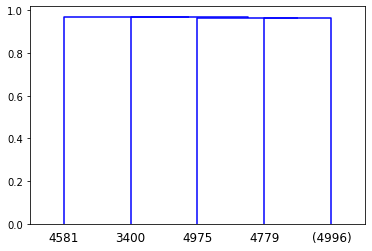

In [44]:
plot_dendrogram(cluster, truncate_mode='level', p=3)
plt.show()

In [43]:
tfidf = TfidfVectorizer(max_features=100)
X = tfidf.fit_transform(pol_df['quotedTweet_content']).todense()

In [47]:
N = X.shape[0]
idx = np.random.choice(N, size=2000, replace=False)
x = X[idx]
labels = pol_df.quotedTweet_username[idx].tolist()


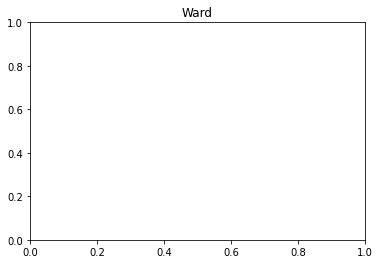

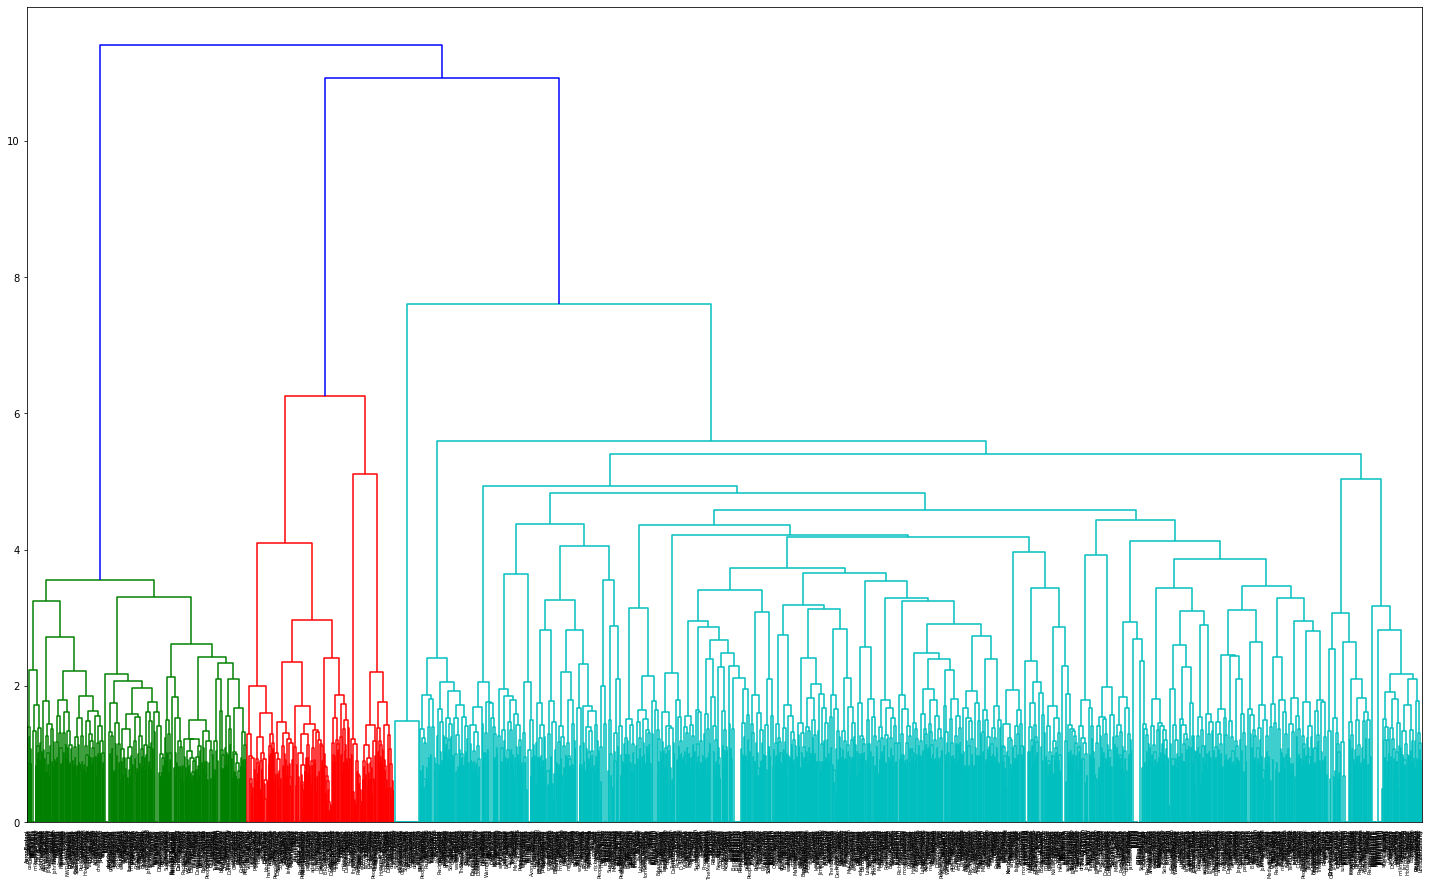

In [53]:
from scipy.spatial.distance import pdist
dist_array = pdist(x)
Z = linkage(dist_array, 'ward')
plt.title("Ward")
plt.figure(figsize = (25,15))
dendrogram(Z, labels=labels)
plt.show()

In [50]:
dist_array

array([1.35300036, 1.24726858, 1.35188895, ..., 1.31124229, 1.37909705,
       1.27146317])